## Importing Libraries

In [352]:
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

In [353]:
# Setting the random seed for TensorFlow and NumPy
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)


In [354]:
# load the dataset
DATASET_PATH = 'data/train/audio'

In [355]:
# Reading Directory Contents
commands = np.array(tf.io.gfile.listdir(str(DATASET_PATH)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print('Commands:', commands)

Commands: ['bed' 'bird' 'cat' 'dog' 'down' 'eight' 'five' 'four' 'go' 'happy'
 'house' 'left' 'marvin' 'nine' 'no' 'off' 'on' 'one' 'right' 'seven'
 'sheila' 'six' 'stop' 'three' 'tree' 'two' 'up' 'wow' 'yes' 'zero'
 '_background_noise_']


## Train / Test Data Split

In [357]:
train_ds, temp_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=DATASET_PATH,
    batch_size=64,
    validation_split=0.3, # 70% for training, 30% for validation+test
    seed=0,
    output_sequence_length=16000,
    subset='both')

val_ds, test_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=DATASET_PATH,
    batch_size=64,
    validation_split=0.33, # splits the 30% of data into 20% validation and 10% test
    seed=0,
    output_sequence_length=16000,
    subset='both')

label_names = np.array(train_ds.class_names)

print("label names:", label_names)


Found 64727 files belonging to 31 classes.
Using 45309 files for training.
Using 19418 files for validation.
Found 64727 files belonging to 31 classes.
Using 43368 files for training.
Using 21359 files for validation.
label names: ['_background_noise_' 'bed' 'bird' 'cat' 'dog' 'down' 'eight' 'five'
 'four' 'go' 'happy' 'house' 'left' 'marvin' 'nine' 'no' 'off' 'on' 'one'
 'right' 'seven' 'sheila' 'six' 'stop' 'three' 'tree' 'two' 'up' 'wow'
 'yes' 'zero']


In [358]:
print(train_ds.element_spec)
print(val_ds.element_spec)

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))


## Exploratory Data Analysis

In [359]:
# Reducing the dimension
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [360]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [361]:
# Checking the train, test and Validation data

print("For TRAIN")
for example_audio, example_labels in train_ds.take(1):  
  print(example_audio.shape)
  print(example_labels.shape)

print("For VAL")
for example_audio, example_labels in val_ds.take(1):  
  print(example_audio.shape)
  print(example_labels.shape)

print("For TEST")
for example_audio, example_labels in test_ds.take(1):  
  print(example_audio.shape)
  print(example_labels.shape)

For TRAIN
(64, 16000)
(64,)
For VAL
(64, 16000)
(64,)
For TEST
(64, 16000)
(64,)


## Visualizing different samples from each labels

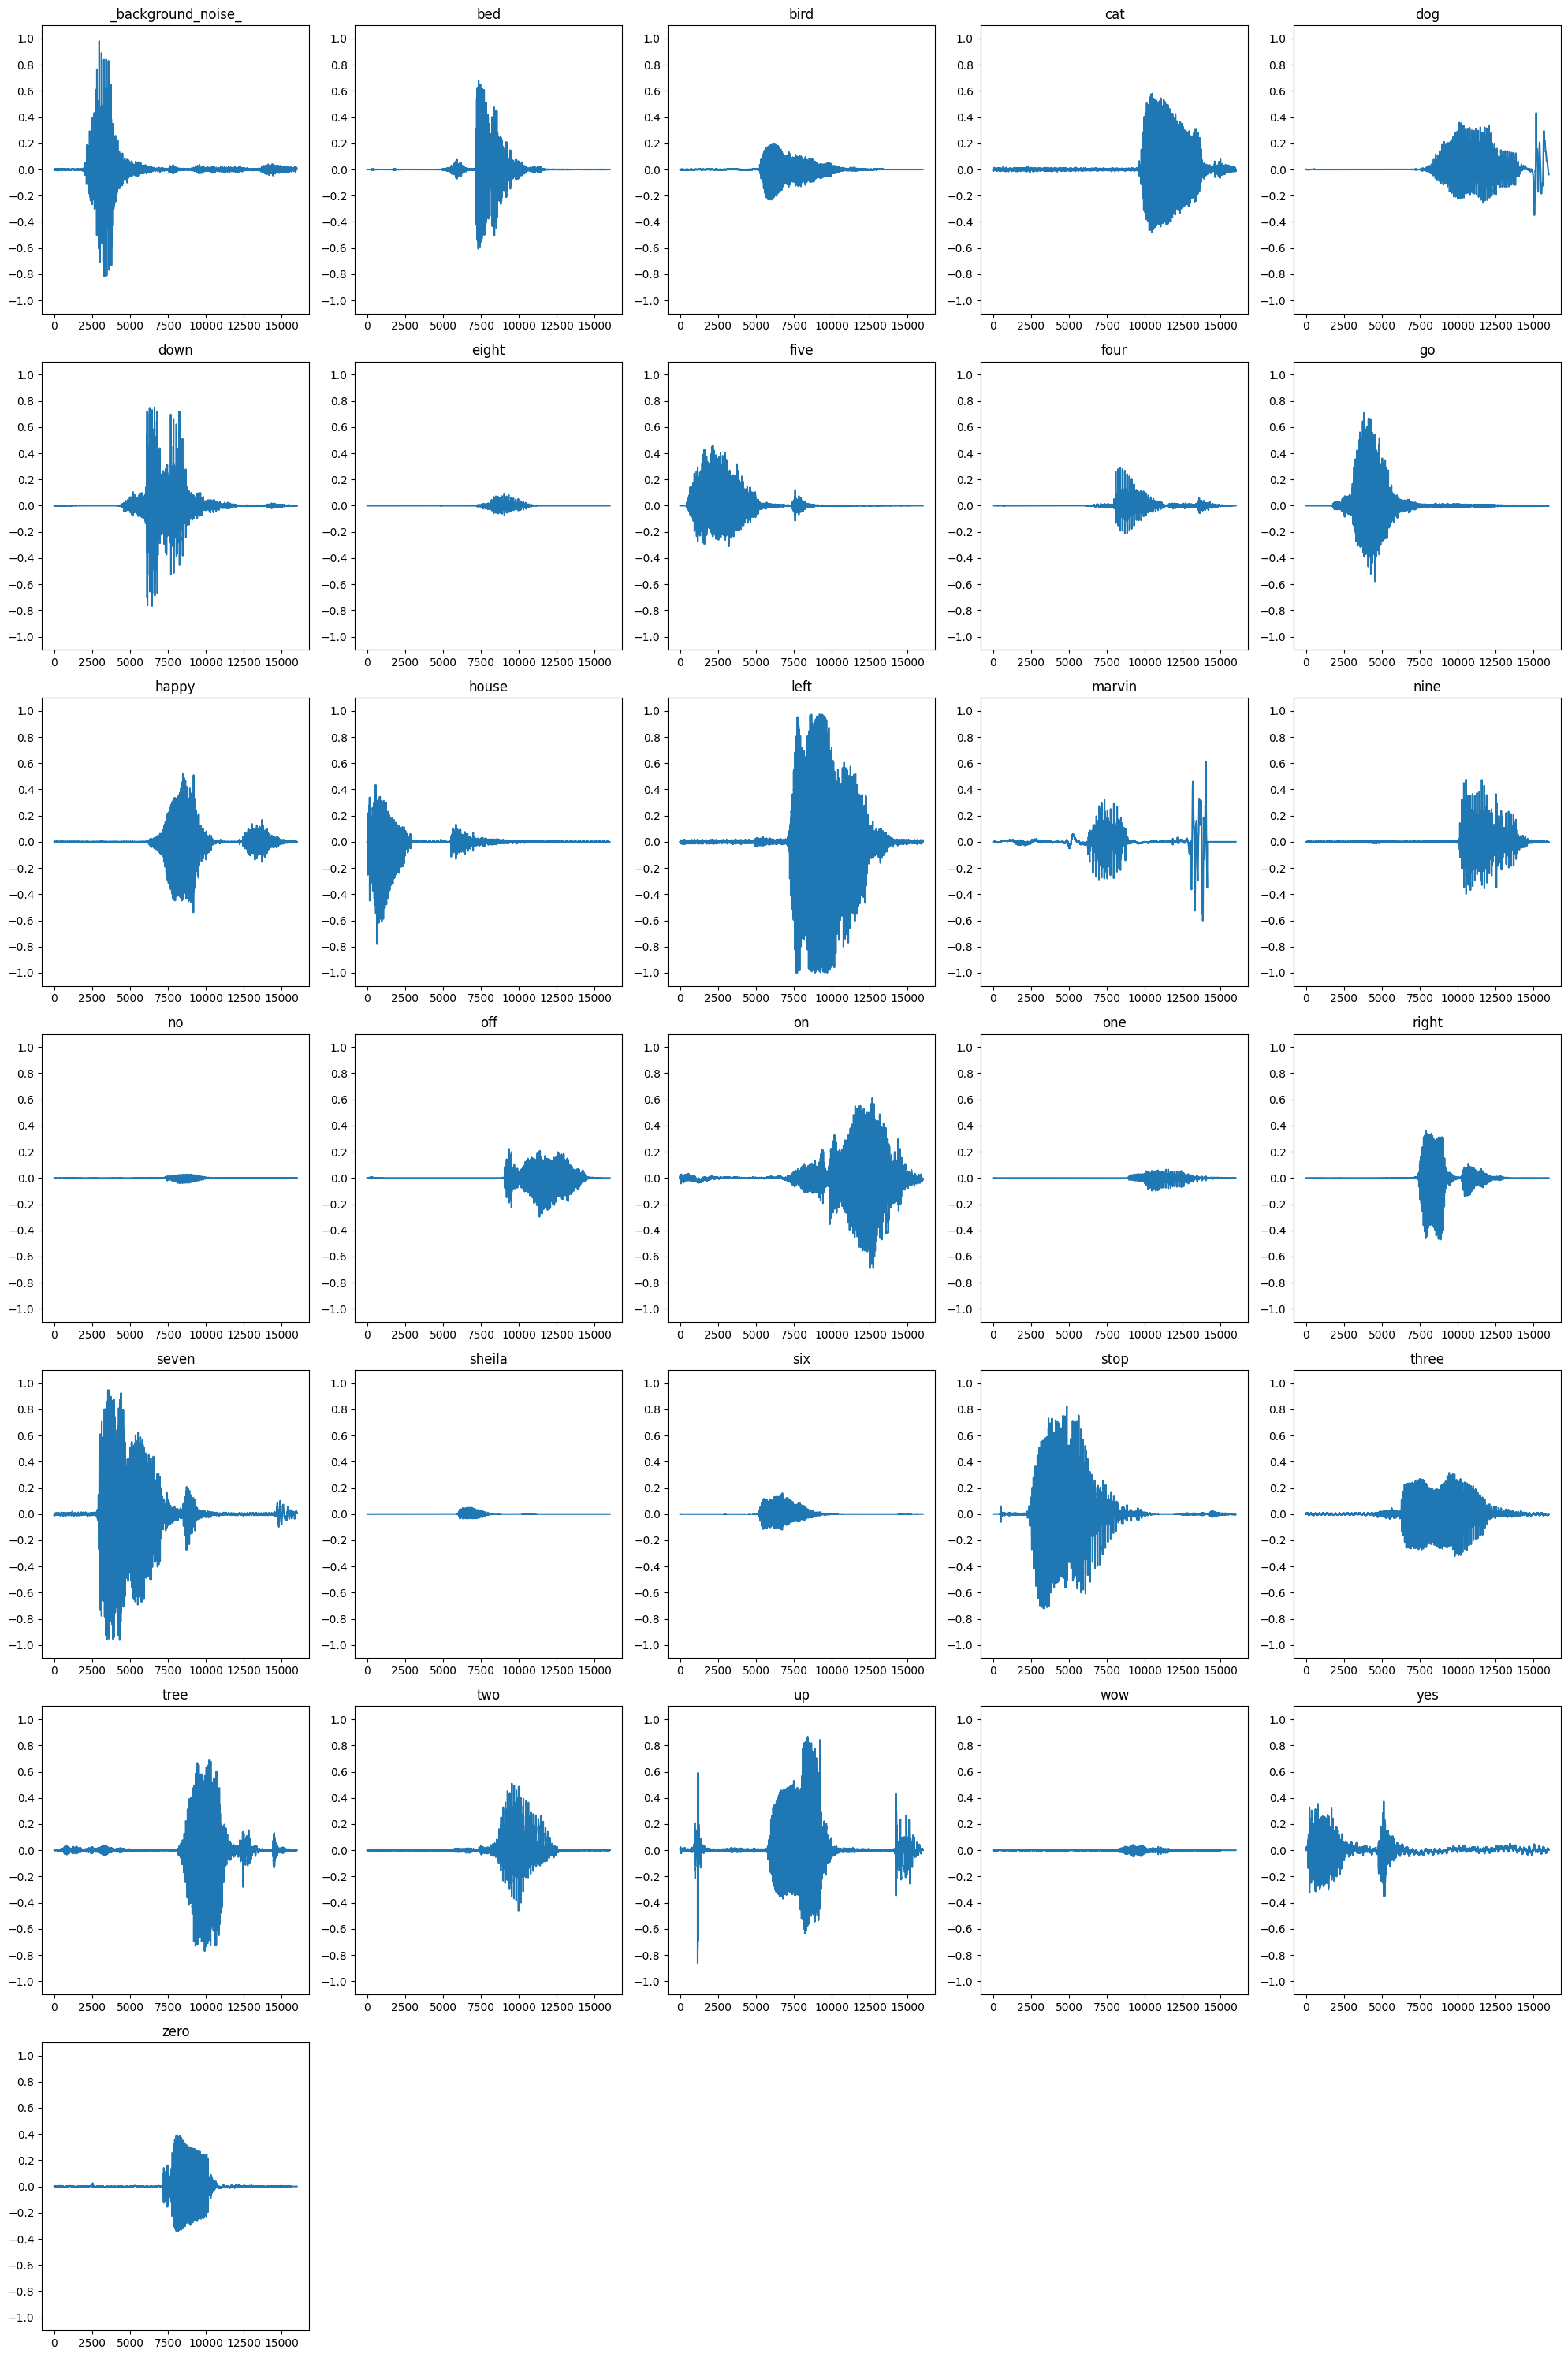

In [362]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20, 30))
n = len(label_names)
cols = 5
rows = (n + cols - 1) // cols

for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[i])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

plt.tight_layout()
plt.show()

## Defining Functions for Feature Engineering

In [363]:
def get_spectrogram(waveform):
  frame_length = 255
  frame_step = 128
  spectrogram = tf.signal.stft(
      waveform, frame_length, frame_step)
  spectrogram = tf.abs(spectrogram)
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram


In [364]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)


In [365]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

## Spectogram Representation of the Dataset

In [366]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

print(val_spectrogram_ds)

<_ParallelMapDataset element_spec=(TensorSpec(shape=(None, 124, 129, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [367]:
for spectrogram, label in test_spectrogram_ds.take(1):
    print("Spectrogram shape:", spectrogram.shape)
    print("Label:", label.numpy())


Spectrogram shape: (64, 124, 129, 1)
Label: [29  7 12 20 12 22 22 25  6 22  2 30 19 25 15 13  9 14  4  7  5 29  8 25
 15 15  6 17 14  9 29 21  4 12 12 29 19  6 12 27 13 18  8  9  5 14 28  8
 11 27 14  2 12  9 30 23 29 17 10  7 15 21 18 12]


In [368]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

## Plotting the Spectograms for different labels and Sample

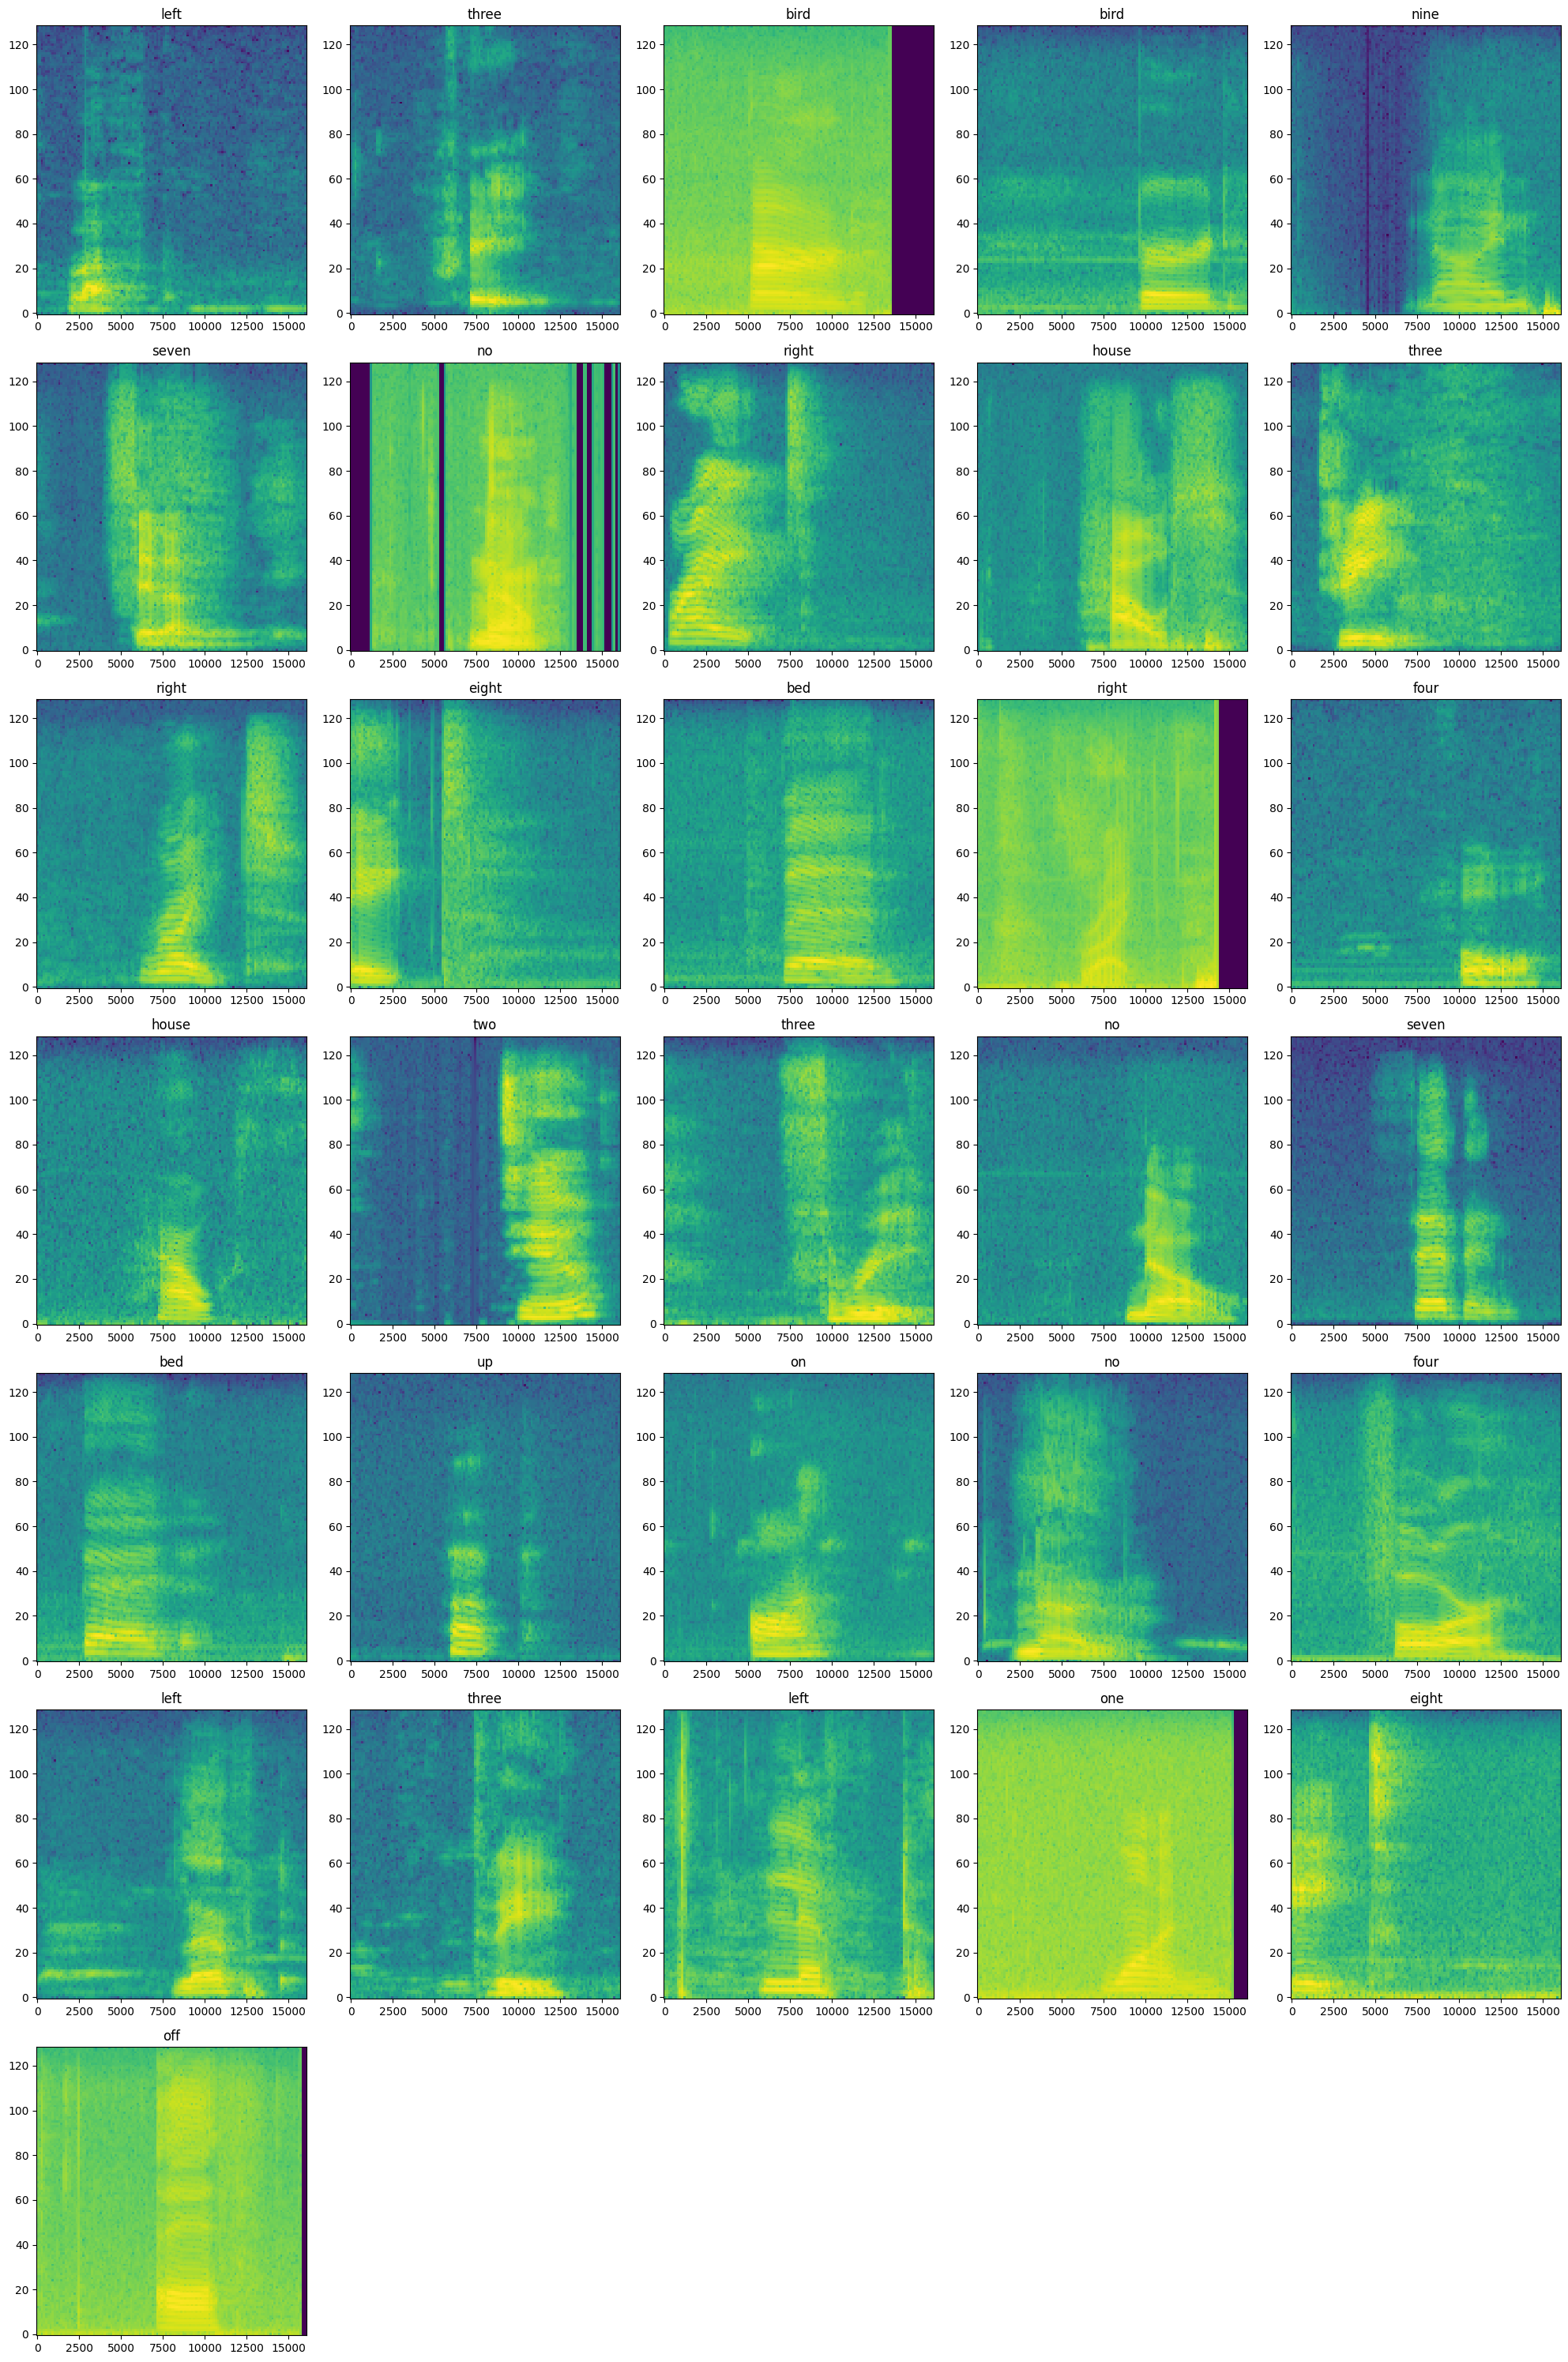

In [370]:
n = len(label_names)
cols = 5
rows = (n + cols - 1) // cols
extra_plots = rows * cols - n

fig, axes = plt.subplots(rows, cols, figsize=(20, 30))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

# Hide the empty subplots in the last row
for i in range(extra_plots):
    r = rows - 1
    c = cols - extra_plots + i
    axes[r][c].axis('off')

plt.tight_layout()
plt.show()


## Model Training

In [371]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

#### Convolutional Neural Network which takes Spectograms as Input and processes them through different Layers

In [372]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
'''Fit the state of the layer to the spectrograms with `Normalization.adapt`
'''
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(128, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()


Input shape: (124, 129, 1)
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_10 (Resizing)      (None, 32, 32, 1)         0         
                                                                 
 normalization_10 (Normaliz  (None, 32, 32, 1)         3         
 ation)                                                          
                                                                 
 conv2d_20 (Conv2D)          (None, 30, 30, 128)       1280      
                                                                 
 conv2d_21 (Conv2D)          (None, 28, 28, 64)        73792     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 14, 14, 64)        0         
 ng2D)                                                           
                                                                 
 dropout_20 (Dropout)     

In [373]:
input_shape = model.input_shape
print("Model input shape:", input_shape)

Model input shape: (None, 124, 129, 1)


#### Compiling the Model

In [374]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

#### Defining the Number of Epochs and Running the training

In [375]:
EPOCHS = 10
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
)

Epoch 1/10


708/708 [==============================] - 178s 251ms/step - loss: 2.2193 - accuracy: 0.3643 - val_loss: 1.0761 - val_accuracy: 0.7015
Epoch 2/10
708/708 [==============================] - 138s 194ms/step - loss: 1.3253 - accuracy: 0.6049 - val_loss: 0.7347 - val_accuracy: 0.7968
Epoch 3/10
708/708 [==============================] - 141s 200ms/step - loss: 1.0734 - accuracy: 0.6757 - val_loss: 0.6219 - val_accuracy: 0.8349
Epoch 4/10
708/708 [==============================] - 136s 192ms/step - loss: 0.9405 - accuracy: 0.7146 - val_loss: 0.5043 - val_accuracy: 0.8588
Epoch 5/10
708/708 [==============================] - 135s 191ms/step - loss: 0.8390 - accuracy: 0.7431 - val_loss: 0.4138 - val_accuracy: 0.8819
Epoch 6/10
708/708 [==============================] - 130s 184ms/step - loss: 0.7759 - accuracy: 0.7597 - val_loss: 0.3755 - val_accuracy: 0.8974
Epoch 7/10
708/708 [==============================] - 130s 184ms/step - loss: 0.7273 - accuracy: 0.7761 - val_loss: 0.3383 - val_accura

#### Plotting the Losses

Text(0, 0.5, 'Accuracy [%]')

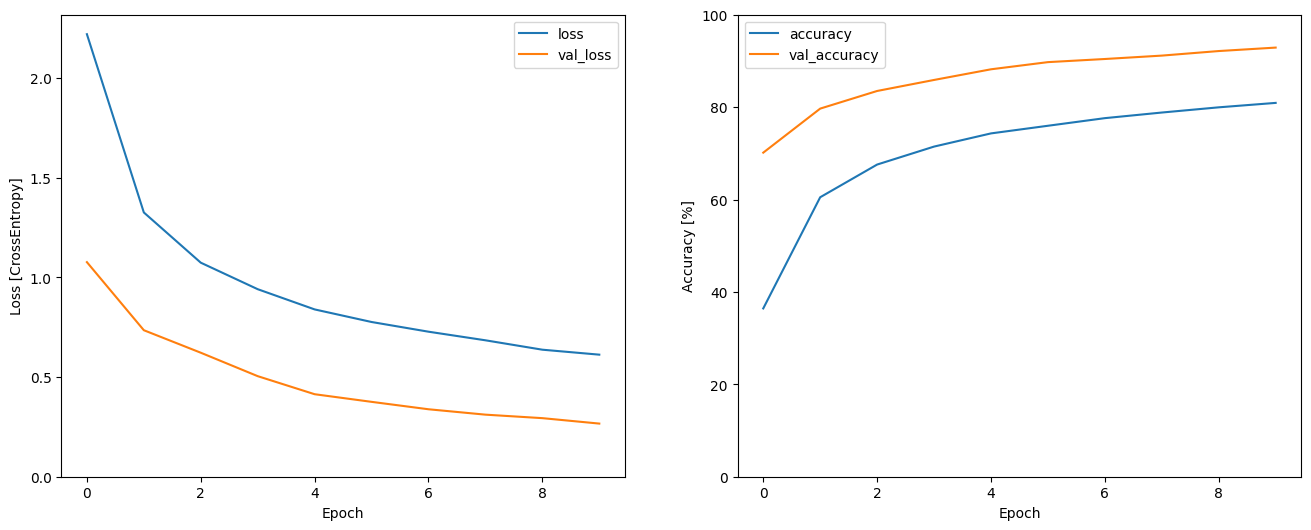

In [377]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

#### Model Evaluation

In [378]:
model.evaluate(test_spectrogram_ds, return_dict=True)

339/339 [==============================] - 50s 145ms/step - loss: 0.2671 - accuracy: 0.9280


{'loss': 0.2671298682689667, 'accuracy': 0.9280051589012146}

#### Model Prediction

In [379]:
y_pred = model.predict(test_spectrogram_ds)

339/339 [==============================] - 13s 38ms/step


In [380]:
y_pred = tf.argmax(y_pred, axis=1)

In [381]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

#### Taking a sample of Audio from test and Predicting the command

In [382]:
x = './data/test/audio/clip_0a0aa67a9.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
x_labels = label_names

print(prediction)

tf.Tensor(
[[-14.058565    -4.410537    -4.115405    -6.830332    -1.6743127
   -0.8517559   -9.53526     -0.3331983    6.8622775   -0.21015504
  -11.681068    -5.928506    -5.7006664   -4.5200124   -3.7142503
   -4.947523    -0.20165753   1.9825276    0.8359482   -7.1935706
   -2.6966133   -4.938412    -8.221444    -1.1068516   -3.575165
   -6.692874    -1.6930918   -6.8998923   -0.48478052 -10.315138
   -3.8623114 ]], shape=(1, 31), dtype=float32)


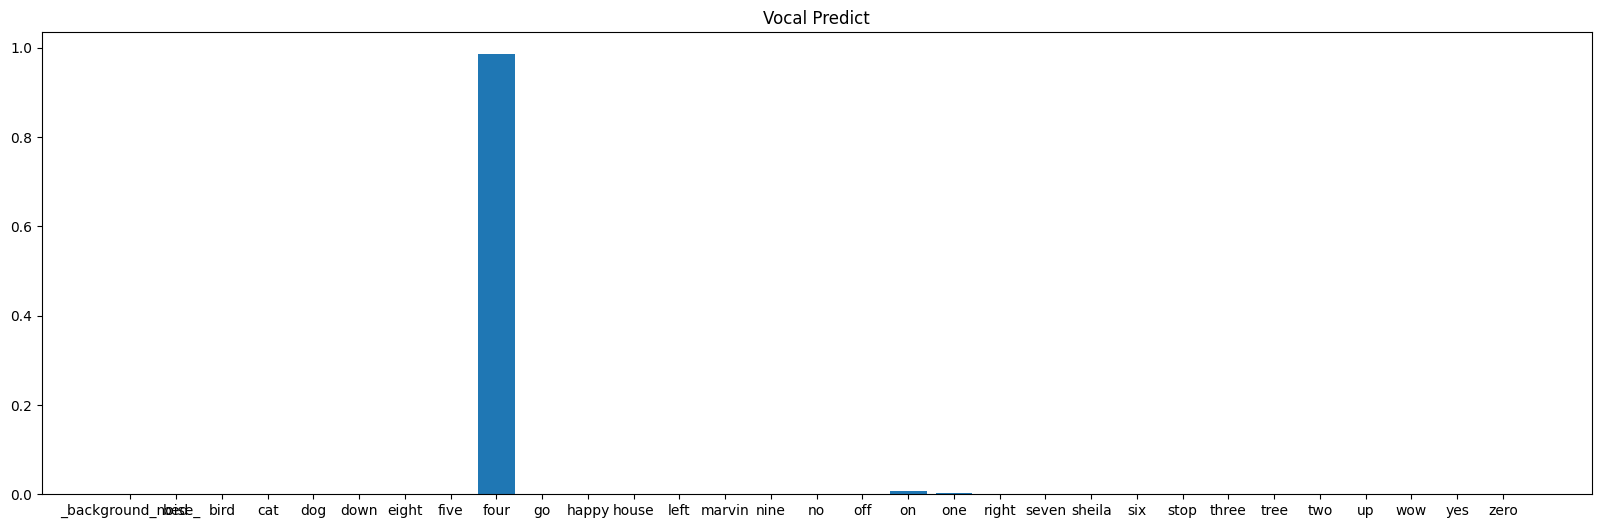

In [383]:
plt.figure(figsize=(20, 6)) 
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('Vocal Predict')
plt.show()

display.display(display.Audio(waveform, rate=16000))